In [3]:
import pandas as pd
import geopandas
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('fivethirtyeight')

import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score 

In [4]:
#df = pd.read_csv('../datasets/df_dummy.csv',index_col=0)
df = pd.read_csv('../datasets/df_dummies2.csv',index_col=0)

In [5]:
df = df.rename(columns={'round_distance_0': 'dist<0.1_miles','round_distance_1': 'dist<0.2_miles','round_distance_2': 'dist<0.3_miles','round_distance_3': 'dist<0.4_miles','round_distance_4': 'dist<0.5_miles','round_distance_5': 'dist>0.5_miles'})

In [6]:
df[['RegionID','zip_code']] = df[['RegionID','zip_code']].astype('category')

In [7]:
pd.set_option('display.max_columns',320)

In [8]:
df = df.reset_index(drop=True)

In [9]:
df = df[df.above_median!=-1]
df.above_median = np.where(df.above_median==2,0,df.above_median)

In [10]:
X = df.drop(columns=['neighborhood','rent_estimate', 'median_nb_rents','num_within_dist','address','sale_date','sale_price','above_median','geometry','stat_lng','stat_lat','add_lng','add_lat','dist_miles'])
y = df.above_median

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=4)

# Functions to Build Models, Print Metrics and Plot ROC Curve

In [67]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True):
    start = time.time()
    
    clf = model
    clf.fit(X_train,y_train)
    print('Runtime: {} seconds'.format(time.time()-start))
    
    y_hat_test = clf.predict(X_test)
    print('Runtime: {} seconds'.format(time.time()-start))
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 0]
    print('Runtime: {} seconds'.format(time.time()-start))
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score, fpr, tpr, thresholds

In [79]:
def print_model_metrics(y_pred,y_score):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    true_negative  = cm[0,0]
    false_positive = cm[0,1]
    false_negative = cm[1,0]
    true_positive  = cm[1,1]

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('accuracy:   {}'.format(round(accuracy,4)))
    print('precision:  {}'.format(round(precision,4)))
    print('recall:     {}'.format(round(recall,4)))
    print('F1          {}'.format(round(f1,4)))
    print('AUC:        {}'.format(round(auc(fpr, tpr),4)))

In [73]:
def print_rf_model_metrics(y_pred,y_score):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    true_negative  = cm[0,0]
    false_positive = cm[0,1]
    false_negative = cm[1,0]
    true_positive  = cm[1,1]

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('accuracy:   {}'.format(round(accuracy,4)))
    print('precision:  {}'.format(round(precision,4)))
    print('recall:     {}'.format(round(recall,4)))
    print('F1          {}'.format(round(f1,4)))
    print('AUC:        {}'.format(round(auc(tpr, fpr),4)))

In [74]:
def plot_roc_curve(fpr, tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    #print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# Grid Search / Parameter Tuning

In [88]:
#Logistic Regression
log_param_grid = {'C': [0.001, 0.01, 0.1,1,10] } 

#Random Forest
rf_param_grid = {"n_estimators": range(20, 100, 10),
                  "max_depth": range(4, 40, 4),
                  "min_samples_leaf": range(2, 100, 8),
                  #"max_features": range(1, len(X.columns)+1),
                  "min_samples_split": range(2, 10,2),
                  #"bootstrap": [True],
                  "criterion": ["gini", "entropy"]
                }

#Gradient Boost
gb_param_grid = {'n_estimators': [500],
                  'learning_rate':[0.001, 0.01,0.1,1],
                  'max_depth': [2,4,40],
                  'min_samples_leaf': range(2, 100, 8),
                  'min_samples_split': range(2, 10, 2),
                  #'max_features': range(1, len(X.columns)+1)
                }

#AdaBoost
ada_param_grid = {#"base_estimator__criterion" : ["gini", "entropy"],
                   'learning_rate':[0.001, 0.01,0.1,1],
                   #"base_estimator__splitter" :   ["best", "random"],
                   "n_estimators": [5,10,50,100,250]
                 }

In [86]:
def grid_search(clf, param_grid):
    
    start = time.time()

    param_grid = param_grid
    cv = ShuffleSplit(n_splits = 15, test_size = 0.25, random_state = 2)
    
    search = GridSearchCV(clf,param_grid,cv=cv,scoring='roc_auc')
    print('Runtime: {} seconds'.format(time.time()-start))
    
    search.fit(X_train,y_train)
    
    print("Total Runtime for Grid Search: {:.4} seconds".format(time.time() - start))
    print("Testing Accuracy: {:.4}%".format(search.best_score_ * 100))
    print("\nOptimal Parameters: {}".format(search.best_params_))
    

# LOGISTIC REGRESSION

In [87]:
grid_search(LogisticRegression(),log_param_grid)

Runtime: 4.506111145019531e-05 seconds
Total Runtime for Grid Search: 319.6 seconds
Testing Accuracy: 51.27%

Optimal Parameters: {'C': 0.001}


In [17]:
log_clf, log_y_pred, log_y_score, log_fpr, log_tpr, log_thresholds = build_model(LogisticRegression(C=.001), 
                                                         X_train, X_test, y_train, y_test,decision_function=True)

Runtime: 1.1920928955078125e-06 seconds
Runtime: 4.2210869789123535 seconds
Runtime: 5.092461109161377 seconds
Runtime: 5.89149808883667 seconds
Total Runtime: 5.901079177856445 seconds


[[   10 14514]
 [   33 24184]]
accuracy:   0.6245
precision:  0.6249
recall:     0.9986
F1          0.7688
AUC:        0.5131


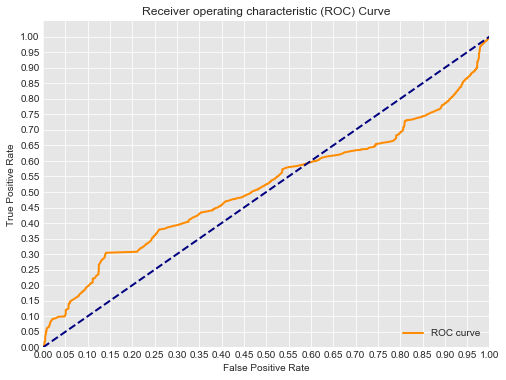

In [89]:
print_model_metrics(log_y_pred,log_y_score)
plot_roc_curve(log_fpr,log_tpr)

# RANDOM FOREST CLASSIFIER

In [ ]:
grid_search(RandomForestClassifier(),rf_param_grid)

Runtime: 2.5987625122070312e-05 seconds
Runtime: 0.00035691261291503906 seconds


In [76]:
rf_clf, rf_y_pred, rf_y_score, rf_fpr, rf_tpr, rf_thresholds = build_model(RandomForestClassifier(), 
                                                         X_train, X_test, y_train, y_test,decision_function=False)

Runtime: 7.406030178070068 seconds
Runtime: 8.351808071136475 seconds
Runtime: 9.38559603691101 seconds
Total Runtime: 9.400904893875122 seconds


[[ 8579  5945]
 [ 3786 20431]]
accuracy:   0.7488
precision:  0.7746
recall:     0.8437
F1          0.8077
AUC:        0.8224


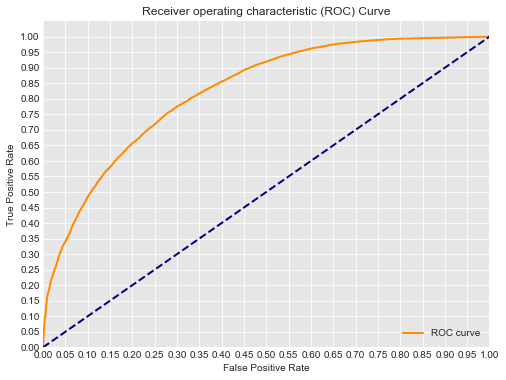

In [81]:
print_rf_model_metrics(rf_y_pred,rf_y_score)
plot_roc_curve(rf_tpr,rf_fpr)

# GRADIENT BOOSTING CLASSIFIER

In [29]:
#grid_search(GradientBoostingClassifier(),gb_param_grid)

In [22]:
gb_clf, gb_y_pred, gb_y_score, gb_fpr, gb_tpr, gb_thresholds = build_model(GradientBoostingClassifier(), 
                                                         X_train, X_test, y_train, y_test,decision_function=True)

Runtime: 1.9073486328125e-06 seconds
Runtime: 70.81424498558044 seconds
Runtime: 71.8943681716919 seconds
Runtime: 72.8976469039917 seconds
Total Runtime: 72.90459299087524 seconds


[[ 6477  8047]
 [ 3164 21053]]
accuracy:   0.7106
precision:  0.7235
recall:     0.8693
F1          0.7897
AUC:        0.7597


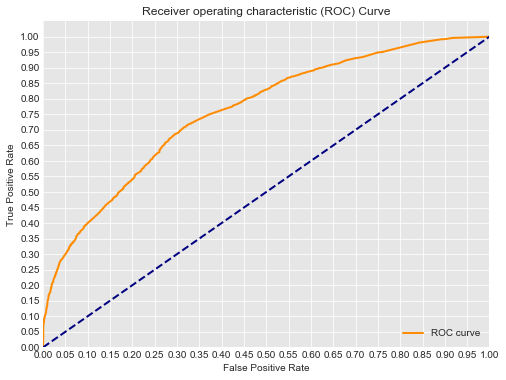

In [82]:
print_model_metrics(gb_y_pred,gb_y_score)
plot_roc_curve(gb_fpr,gb_tpr)

# ADABOOST CLASSIFIER

In [47]:
#grid_search(AdaBoostClassifier(),ada_param_grid)

#####RESULTS#####
# Runtime: 8.0108642578125e-05 seconds ### ONE HOUR ###
# Total Runtime for Grid Search: 4.01e+03 seconds
# Testing Accuracy: 69.98%

# Optimal Parameters: {'learning_rate': 1, 'n_estimators': 100}

Runtime: 8.0108642578125e-05 seconds
Total Runtime for Grid Search: 4.01e+03 seconds
Testing Accuracy: 69.98%

Optimal Parameters: {'learning_rate': 1, 'n_estimators': 100}


In [54]:
ada_clf, ada_y_pred, ada_y_score, ada_fpr, ada_tpr, ada_thresholds = build_model(AdaBoostClassifier(
                                                                                learning_rate=1, n_estimators=200), 
                                                                                X_train, X_test, y_train, y_test,
                                                                                decision_function=True)

Runtime: 1.1920928955078125e-06 seconds
Runtime: 152.21973609924316 seconds
Runtime: 158.85814929008484 seconds
Runtime: 165.1559600830078 seconds
Total Runtime: 165.1664741039276 seconds


[[ 7407  7117]
 [ 4135 20082]]
accuracy:   0.7096
precision:  0.7383
recall:     0.8293
F1          0.7812
AUC:        0.7681


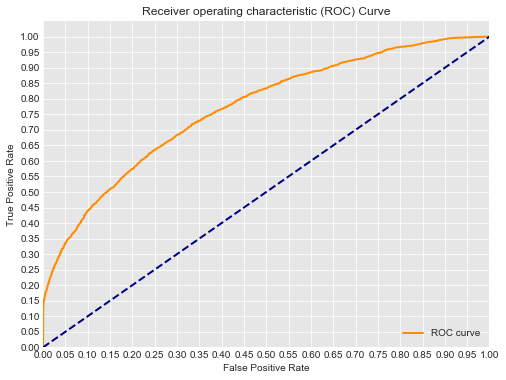

In [55]:
print_model_metrics(ada_y_pred,ada_y_score)
plot_roc_curve(ada_fpr,ada_tpr)

# n_estimators = 200 results
# [[ 7214  7310]
#  [ 4126 20091]]
# accuracy:   0.7048
# precision:  0.7332
# recall:     0.8296
# F1          0.7784
# AUC:        0.7577

# SUPPORT VECTOR MACHINES